In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

sns.set_style('whitegrid')

In [2]:
class Tips:
    def __init__(self, data):
        self.data = data

    def check_null(self):
        if self.data.isna().any().any():
            print(self.data.isna().sum())
        else:
            print('No null values present in the dataset ')

    def cat_encoding(self, cols=None, by='ordinal'):
        if cols is None:
            cols = self.data.select_dtypes(['object', 'category']).columns

        if by.lower() != 'ordinal':
            new_data = pd.get_dummies(self.data.loc[:, cols], drop_first=True)
            self.data = pd.concat([self.data, new_data], axis=1)
            self.data.drop(cols, axis=1, inplace=True)
            return self.data
        else:
            for col in cols:
                self.data[col] = LabelEncoder().fit_transform(self.data.loc[:, col])

    def eda(self):
        #Outliers
        self.data.plot(kind='box')
        plt.show()
        # Distribution
        self.data.plot(kind='hist')
        plt.show()
        # Correlation
        sns.pairplot(self.data)
        plt.show()

    def custom_scaling(self, cols=None):
        if cols is None:
            cols = self.data.select_dtypes(include=[int, float])
        for col in cols:
            self.data[col] = (self.data.loc[:, col] - self.data.loc[:, col].mean()) / np.std(self.data.loc[:, col])

    def get_vif(self,x):
        from statsmodels.stats.outliers_influence import variance_inflation_factor
        self.vif_data = pd.DataFrame()
        self.vif_data['Features'] = x.columns
        self.vif_data['VIF'] = [variance_inflation_factor(x.values, i) for i in range(len(x.columns))]
        return self.vif_data

    def remove_multi_collinearity(self,x,threshold=10):
        vif = self.get_vif(x)
        maxi = vif.loc[:,'VIF'].max()
        while (maxi > threshold):
            print(vif)
            to_drop = vif[vif.VIF == maxi].Features
            X.drop(to_drop,axis=1,inplace=True)
            vif = self.get_vif(X)
            maxi = vif.loc[:,'VIF'].max()

    def get_feature_importance(self,x,y):
        rfr = RandomForestRegressor(max_depth = 50,n_jobs=-1).fit(x,y)
        feat_imp = pd.Series(rfr.feature_importances_, index=x.columns)
        feat_imp.plot(kind='barh')
        plt.show()

In [3]:
def get_grouped_plot(cols=None):
    if cols is None:
        cols = dataset.select_dtypes(['object','category'])
    for col in cols:
        dataset.groupby(col).mean().plot(kind='bar')
        plt.show()

def build_model():
    rfr = RandomForestRegressor(max_depth=5, n_estimators=130,n_jobs=-1).fit(X_train, y_train)
    lin = LinearRegression()
    rfr_cvs = cross_val_score(rfr, X, y, cv=10,scoring='neg_mean_squared_error', n_jobs=-1)
    lin_cvs = cross_val_score(lin, X, y, cv=10,scoring='neg_mean_squared_error', n_jobs=-1)
    print(f'FOR RANDOM FOREST : {rfr_cvs}\
     AND MEAN : {rfr_cvs.mean()}')
    print(f'FOR LINEAR REGRESSION : {lin_cvs}\
     AND MEAN : {lin_cvs.mean()}')
    return rfr_cvs

No null values present in the dataset 


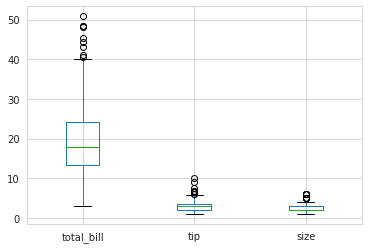

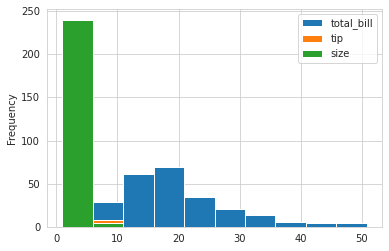

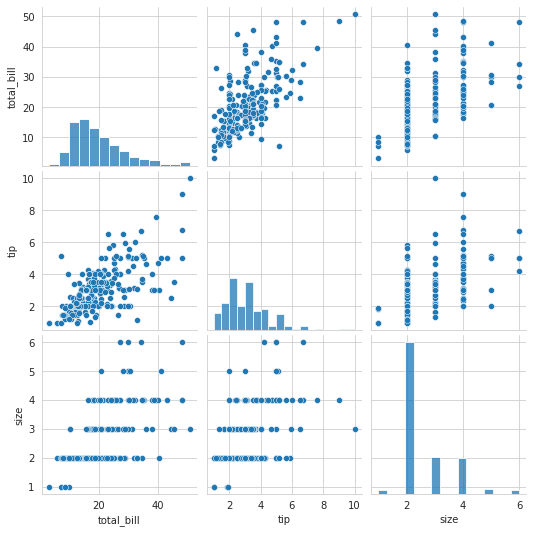

In [4]:
dataset = sns.load_dataset('tips')
obj = Tips(dataset)
obj.check_null()
obj.eda()

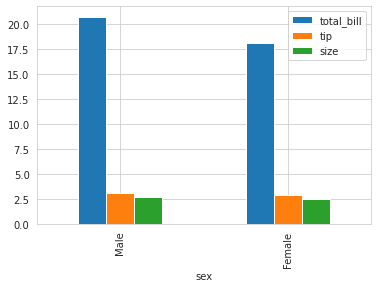

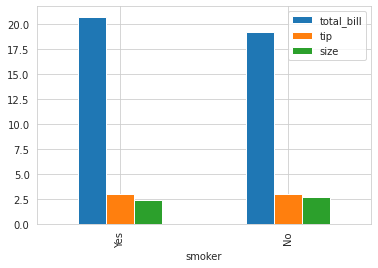

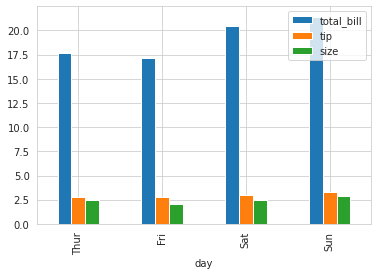

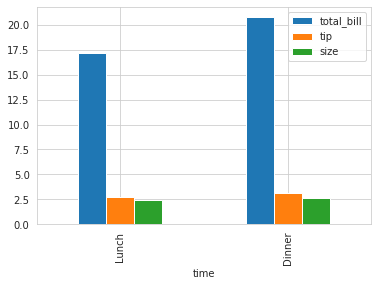

In [5]:
get_grouped_plot()

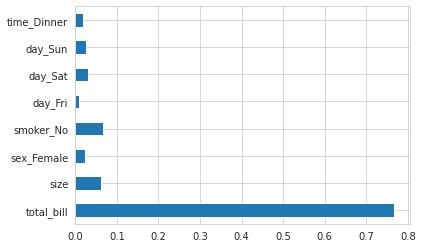

In [6]:
dataset = obj.cat_encoding(by='nominal')
X = dataset.drop('tip',axis=1)
y = dataset.loc[:,'tip']
#vif_data = obj.get_vif(X)
#obj.remove_multi_collinearity(X)
obj.get_feature_importance(X,y)

FOR RANDOM FOREST : [-0.89538924 -0.78687696 -0.6141515  -0.81310313 -0.63072464 -0.73325483
 -1.24367229 -2.48939312 -1.21527073 -1.24909865]     AND MEAN : -1.0670935089998157
FOR LINEAR REGRESSION : [-0.76941162 -0.76256223 -0.58708419 -0.82812597 -0.97483966 -0.64455527
 -1.45640584 -2.90756819 -1.46500059 -1.1496981 ]     AND MEAN : -1.1545251658647895



RMSE OF RANDOM FOREST IS :  1.2385017183295597
IN WORST CASE RMSE POSSIBLE FOR MODEL IS -2.48939312218812        IN AVG  CASE RMSE POSSIBLE IS  : -1.0670935089998157        IN BEST CASE RMSE POSSIBLE IS : -0.6141515039516307


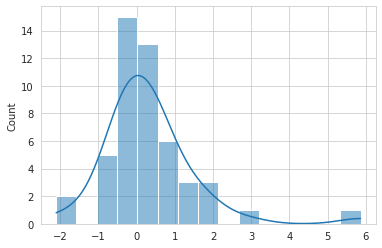

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8)
rfr_cvs = build_model()
rfr = RandomForestRegressor(max_depth=5, n_estimators=130,n_jobs=-1).fit(X_train, y_train)
rfr_pred = rfr.predict(X_test)
print('\n\n')
print('RMSE OF RANDOM FOREST IS : ', np.sqrt(mean_squared_error(y_test, rfr_pred)))
print(f'IN WORST CASE RMSE POSSIBLE FOR MODEL IS {rfr_cvs.min()}\
        IN AVG  CASE RMSE POSSIBLE IS  : {rfr_cvs.mean()}\
        IN BEST CASE RMSE POSSIBLE IS : {rfr_cvs.max()}')

dataset = pd.concat([X_test,y_test,pd.Series(rfr_pred,index=X_test.index)._set_name('predictions')]
                             ,axis=1)

sns.histplot(dataset.tip - dataset.predictions,kde=True)
plt.show()